In [1]:
#%matplotlib widget
import control.matlab as matlab
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
#マルチコプタサンプルの数値例計算　Ver 0.0 (2021.7.4 (c)Kouhei)

###重力加速度
grav=9.80665

###モータのパラメータ
Jm=3.4e-6
Lm=3.7e-6
Rm=0.12
Km=3.28e-3
Dm=0.0
Qf=0.0

###プロペラのパラメータ
Ct=8.3e-7
Cq=3.0e-8

###各パーツの質量(kg)
mm=0.045 #モータ+プロペラ 0.045
mf=0.19 #フレーム
ml=0.02 #脚
mb=0.26 #電池

###各パーツの大きさ(m)
##モータ
Dim=0.038 #直径
rm=Dim/2 #半径
hm=0.016 #高さ

##フレーム
ef=0.292 #長辺の長さ
af=0.127 #１本のアームの根本からの長さ
aw=ef-2*af #アームの幅
df=(ef-af)/np.sqrt(2) #フレームの中心とフレームの空き空間の中心距離

##脚
Dl=0.03 #脚の直径
rl=Dl/2 #脚の半径
hl=0.036 #脚の高さ

##電池
hb=0.016 #電池高さ
wb=0.05 #電池幅
lb=0.15 #電池長さ

###各パーツの位置関係
##x軸
mlx=0.0 #モータ＋プロペラと脚の距離（x軸）
fbx=0.0 #フレームと電池の距離（x軸）
flx=0.18/2 #フレームと脚の距離（x軸）
llx=0.18 #脚の間隔
mmx=0.18 #モータの間隔
mfx=0.18/2
##y軸
mly=0.0 #モータ＋プロペラと脚の距離（y軸）
fby=0.0 #フレームと電池の距離（y軸）
fly=0.18/2 #フレームと脚の距離（y軸）
lly=0.18 #脚の間隔
mmy=0.18 #モータの間隔
mfy=0.18/2
##z軸
mlz=0.046 #モータ＋プロペラと脚の距離（z軸）
fbz=0.018 #フレームと電池の距離（z軸）
flz=0.028 #フレームと脚の距離（z軸）

###各パーツの機体重心を原点とした座標
##x軸
mlFR=2*ml
mlRR=2*ml
mmFR=2*mm
mmRR=2*mm
Ax=np.matrix([[2*mlFR, 2*mlRR, mb, mf, 2*mmFR, 2*mmRR],\
              [1,-1, 0, 0, 0, 0],\
              [0, 0, 0, 0, 1,-1],\
              [0, 0, 1,-1, 0, 0],\
              [1, 0, 0,-1, 0, 0],\
              [0, 0, 0,-1, 1, 0]])
Bx=np.matrix([[0],[llx],[mmx],[fbx],[mfx],[flx]])
Xa=np.linalg.inv(Ax)*Bx
lFRx=lFLx=Xa[0,0]
lRRx=lRlx=Xa[1,0]
bx=Xa[2,0]
fx=Xa[3,0]
mFRx=mFLx=Xa[4,0]
mRRx=mRLx=Xa[5,0]

##y軸
mlRR=2*ml
mlRL=2*ml
mmRR=2*mm
mmRL=2*mm
Ay=np.matrix([[2*mlRR, 2*mlRL, mb, mf, 2*mmRR, 2*mmRL],\
              [1,-1, 0, 0, 0, 0],\
              [0, 0, 0, 0, 1,-1],\
              [0, 0, 1,-1, 0, 0],\
              [1, 0, 0,-1, 0, 0],\
              [0, 0, 0,-1, 1, 0]])
By=np.matrix([[0],[lly],[mmy],[fby],[mfy],[fly]])
Ya=np.linalg.inv(Ay)*By
lFRy=lRRy=Ya[0,0]
lFLy=lRLy=Ya[1,0]
by=Ya[2,0]
fy=Ya[3,0]
mFRy=mRRy=Ya[4,0]
mFLy=mRLy=Ya[5,0]

##z軸
Az=np.matrix([[4*ml, mb, mf, 4*mm],\
              [-1, 0, 0, 1],\
              [ 0,-1, 1, 0],\
              [-1, 0, 1, 0]])
Bz=np.matrix([[0],[mlz],[fbz],[flz]])
Za=np.linalg.inv(Az)*Bz
lz=Za[0,0]
bz=Za[1,0]
fz=Za[2,0]
mz=Za[3,0]


###各パーツの慣性モーメント
##モータ
Imx=Imy=0.25*mm*rm**2+mm*hm**2/12
Imz=0.5*mm*rm**2

##フレーム
#計算準備
sf=4*(af*aw)+aw**2 #フレームの上面から見た面積
se=af**2 #空白部分の面積
sl=aw*ef #長い長方形の面積
sa=aw*af #アームの面積
mfs=mf*ef**2/sf #空白部分が満たされていたときの質量
mfe=mf*se/sf #空白部分の質量
mfl=mf*sl/sf #長い長方形の質量
ma=mf*sa/sf #アームの質量
#ここから慣性モーメント
Icg= mfe*af**2/6 + mfe*df**2 #空き空間に正方形の物体が有ったとしたときの慣性モーメント
Ifx=Ify=mfl*(ef**2+aw**2)/12+2*ma*(af**2+aw**2)/12
Ifz=mfs*ef**2/6-4*Icg

##脚
Ilx=Ily=0.5*ml*rl**2
Ilz= 0.25*ml*rl**2+ ml*hl**2/12

##電池
Ibx=mb*(wb**2+hb**2)/12
Iby=mb*(lb**2+hb**2)/12
Ibz=mb*(wb**2+lb**2)/12

###各パーツの重心からの距離
##xz&yz平面
dlxz=dlyz=np.sqrt(lFRx**2 + lz**2)
dbxz=dbyz=np.sqrt(  bx**2 + bz**2)
dfxz=dfyz=np.sqrt(  fx**2 + fz**2)
dmxz=dmyz=np.sqrt(mFRx**2 + mz**2)
#print('dlxz={:10.2e} \ndbxz={:10.2e} \ndfxz={:10.2e} \ndmxz={:10.2e}\n'.format(dlxz,dbxz,dfxz,dmxz))

##xy平面
dlxy=np.sqrt(lFRx**2 + lFRy**2)
dbxy=np.sqrt(  bx**2 + by**2)
dfxy=np.sqrt(  fx**2 + fy**2)
dmxy=np.sqrt(mFRx**2 + mFRy**2)
#print('dlxy={:10.2e} \ndbxy={:10.2e} \ndfxy={:10.2e} \ndmxy={:10.2e}\n'.format(dlxy,dbxy,dfxy,dmxy))


###マルチコプタの慣性モーメント
##x軸周り　yz平面
Ix=(4*(Imx + mm*dmyz**2)+\
       Ifx + mf*dfyz**2 +\
       Ibx + mb*dbyz**2 +\
       4*(Ilx + ml*dlyz**2))
##y軸周り　xz平面
Iy=(4*(Imy + mm*dmxz**2)+\
       Ify + mf*dfxz**2 +\
       Iby + mb*dbxz**2 +\
       4*(Ily + ml*dlxz**2))
##z軸周り　xy平面
Iz=(4*(Imz + mm*dmxy**2)+\
    Ifz + mf*dfxy**2 +\
    Ibz + mb*dbxy**2 +\
    4*(Ilz + ml*dlxy**2))

###マルチコプタ質量
Mass=mm*4+mf+ml*4+mb

### 伝達関数パラメータ
omega0=0.5*np.sqrt(Mass*grav/Ct)
e0=Rm*((Dm + Km**2/Rm)*omega0 + Cq*omega0**2 + Qf)/Km
taum=Jm*Rm/(Dm*Rm+Km**2+2*Rm*Cq*omega0)
Kw=2*Ct*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Mass
Kroll=mmx*Ct*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Ix
Kpitch=mmx*Ct*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Iy
Kyaw=2*Cq*omega0*Km/(Dm*Rm+Km**2+2*Rm*Cq*omega0)/Iz


###結果表示
print('### Mass ###')
print('{:10.2e}'.format(Mass))

print('\n### Equilibrium value ###')
print('omega0={:10.2e}'.format(omega0))
print('e0={:10.2e}'.format(e0))

print('\n### Transfer Function Parameter ###')
print('tau={:10.2e}'.format(taum))
print('Kw={:10.2e}'.format(Kw))
print('Kroll(Kp)={:10.2e}'.format(Kroll))
print('Kpitch(Kq)={:10.2e}'.format(Kpitch))
print('Kyaw(Kr)={:10.2e}'.format(Kyaw))

print('\n### Inertia　tensor  ###\n')
print('Motor+Prop')
print('Imx={:10.2e}'.format(Imx))
print('Imy={:10.2e}'.format(Imy))
print('Imz={:10.2e}'.format(Imz))
print('\nFrame')
print('Ifx={:10.2e}'.format(Ifx))
print('Ify={:10.2e}'.format(Ify))
print('Ifz={:10.2e}'.format(Ifz))
print('\nLeg')
print('Ilx={:10.2e}'.format(Ilx))
print('Ily={:10.2e}'.format(Ily))
print('Ilz={:10.2e}'.format(Ilz))
print('\nBattery')
print('Ibx={:10.2e}'.format(Ibx))
print('Iby={:10.2e}'.format(Iby))
print('Ibz={:10.2e}'.format(Ibz))

print('\n## Multi Copter ##')
print('Ix={:10.2e}'.format(Ix))
print('Iy={:10.2e}'.format(Iy))
print('Iz={:10.2e}'.format(Iz))

print('\n### Position from Center of Gravity ###')
print('\nMotor Position')
print('Front Right Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mFRx,mFRy,mz))
print('Front Left  Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mFLx,mFLy,mz))
print('Rear  Right Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mRRx,mRRy,mz))
print('Rear  Left  Motor:({:10.2e},{:10.2e},{:10.2e})'.format(mRLx,mRLy,mz))

print('\nFrame Position')
print('({:10.2e},{:10.2e},{:10.2e})'.format(fx,fy,fz))

print('\nBattery Position')
print('({:10.2e},{:10.2e},{:10.2e})'.format(bx,by,bz))

print('\nLeg Position')
print('Front Right Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lFRx,lFRy,lz))
print('Front Left  Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lFLx,lFLy,lz))
print('Rear  Right Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lRRx,lRRy,lz))
print('Rear  Left  Leg:({:10.2e},{:10.2e},{:10.2e})'.format(lRlx,lRLy,lz))


### Mass ###
  7.10e-01

### Equilibrium value ###
omega0=  1.45e+03
e0=  7.05e+00

### Transfer Function Parameter ###
tau=  1.93e-02
Kw=  5.24e-01
Kroll(Kp)=  1.03e+01
Kpitch(Kq)=  9.11e+00
Kyaw(Kr)=  2.15e+00

### Inertia　tensor  ###

Motor+Prop
Imx=  5.02e-06
Imy=  5.02e-06
Imz=  8.12e-06

Frame
Ifx=  8.64e-04
Ify=  8.64e-04
Ifz=  1.47e-03

Leg
Ilx=  2.25e-06
Ily=  2.25e-06
Ilz=  3.28e-06

Battery
Ibx=  5.97e-05
Iby=  4.93e-04
Ibz=  5.42e-04

## Multi Copter ##
Ix=  3.24e-03
Iy=  3.68e-03
Iz=  6.26e-03

### Position from Center of Gravity ###

Motor Position
Front Right Motor:(  9.00e-02,  9.00e-02,  2.32e-02)
Front Left  Motor:(  9.00e-02, -9.00e-02,  2.32e-02)
Rear  Right Motor:( -9.00e-02,  9.00e-02,  2.32e-02)
Rear  Left  Motor:( -9.00e-02, -9.00e-02,  2.32e-02)

Frame Position
(  0.00e+00,  0.00e+00,  5.18e-03)

Battery Position
(  0.00e+00,  0.00e+00, -1.28e-02)

Leg Position
Front Right Leg:(  9.00e-02,  9.00e-02, -2.28e-02)
Front Left  Leg:(  9.00e-02, -9.00e-02, -2.28e-02)

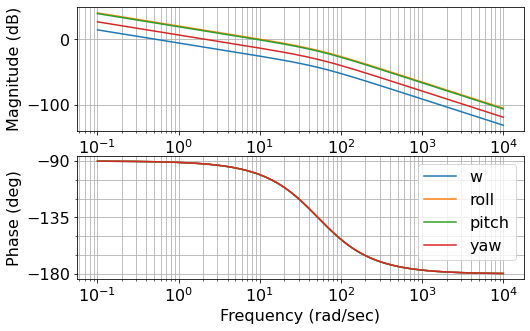

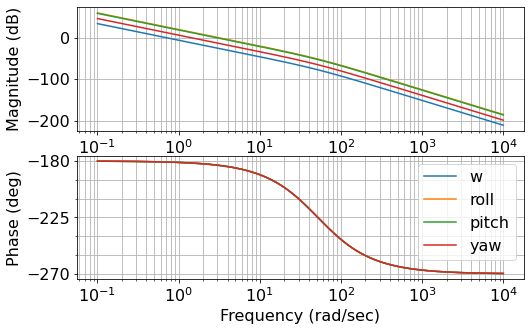

In [3]:
##レート系伝達関数
sysw=matlab.tf(Kw,[taum, 1, 0])
sysp=matlab.tf(Kroll,[taum, 1, 0])
sysq=matlab.tf(Kpitch,[taum, 1, 0])
sysr=matlab.tf(Kyaw,[taum, 1, 0])

#ボード線図描画
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magw,phadew,omegaw = matlab.bode(sysw,wfreq,label='w')
magp,phadep,omegap = matlab.bode(sysp,wfreq,label='roll')
magq,phadeq,omegaq = matlab.bode(sysq,wfreq,label='pitch')
magr,phadew,omegar = matlab.bode(sysr,wfreq,label='yaw')
plt.legend()
plt.show()

##角度・位置系伝達関数
sysaw=matlab.tf(Kw,[taum, 1, 0, 0])
sysap=matlab.tf(Kroll,[taum, 1, 0, 0])
sysaq=matlab.tf(Kpitch,[taum, 1, 0, 0])
sysar=matlab.tf(Kyaw,[taum, 1, 0, 0])

#ボード線図描画
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magw,phadew,omegaw = matlab.bode(sysaw,wfreq,label='w')
magp,phadep,omegap = matlab.bode(sysap,wfreq,label='roll')
magq,phadeq,omegaq = matlab.bode(sysaq,wfreq,label='pitch')
magr,phadew,omegar = matlab.bode(sysar,wfreq,label='yaw')
plt.legend()
plt.show()

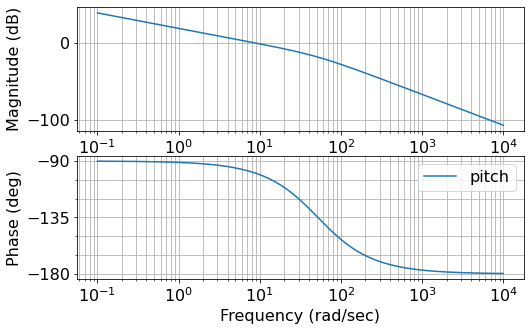

In [4]:
#ピッチレートのボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(sysq,wfreq,label='pitch')
plt.legend()
plt.show()

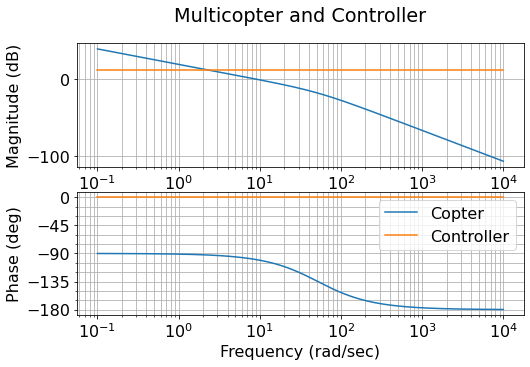

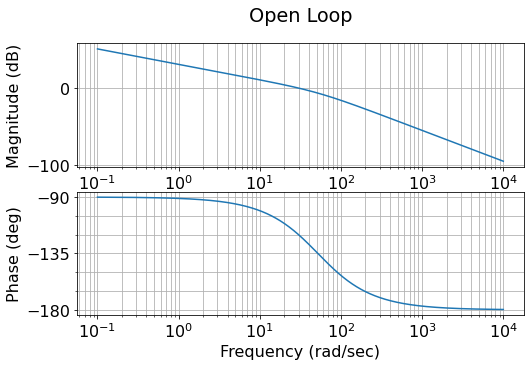

Phase margin=     60.27deg
Gain crossover frequency=     29.66rad/s


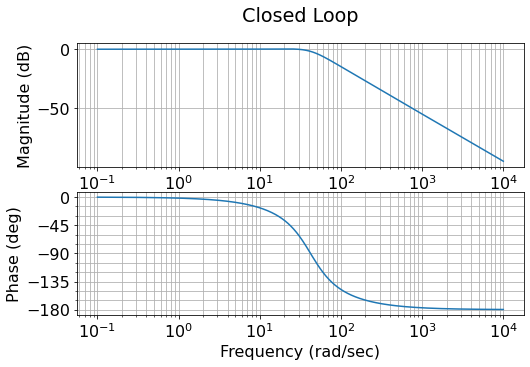

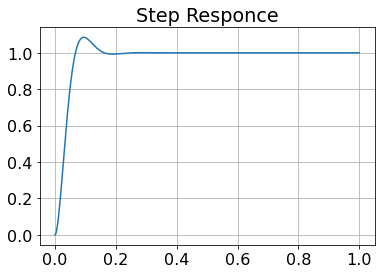

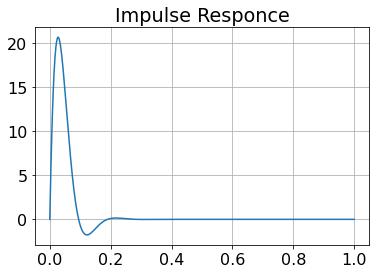

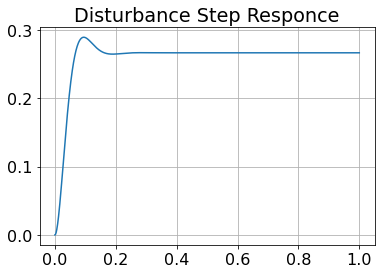

In [5]:
#比例制御
Kp=3.75
cont=matlab.tf([Kp],[0,1])
L=sysq*cont
closesys=matlab.feedback(L)

#制御対象と制御器のボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(sysq,wfreq,label='Copter')
magc,phadec,omegac = matlab.bode(cont,wfreq,label='Controller')
plt.title("Multicopter and Controller",pad=170)
plt.legend()
plt.show()

#開ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(L,wfreq,label='openloop')
plt.title("Open Loop",pad=170)
plt.show()

#位相余裕（ゲイン余裕）
gm, pm, wpc, wgc=matlab.margin(L)
print('Phase margin={:10.2f}deg\nGain crossover frequency={:10.2f}rad/s'.format(pm, wgc))

#閉ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(closesys,wfreq,label='closeloop')
plt.title("Closed Loop", pad=170)
plt.show()

#ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(closesys, t)
plt.plot(t,y)
plt.grid()
plt.title('Step Responce')
plt.show()

#インパルス応答
t=np.linspace(0,1,1000)
y,t=matlab.impulse(closesys, t)
plt.plot(t,y)
plt.grid()
plt.title('Impulse Responce')
plt.show()


###外乱応答
sys_dist=sysq/(1+cont*sysq)

#外乱ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(sys_dist, t)
plt.plot(t,y)
plt.grid()
plt.title('Disturbance Step Responce')
plt.show()

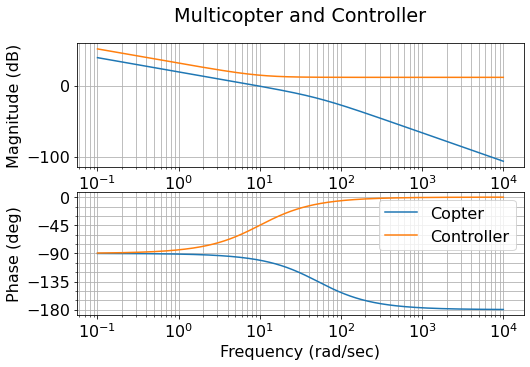

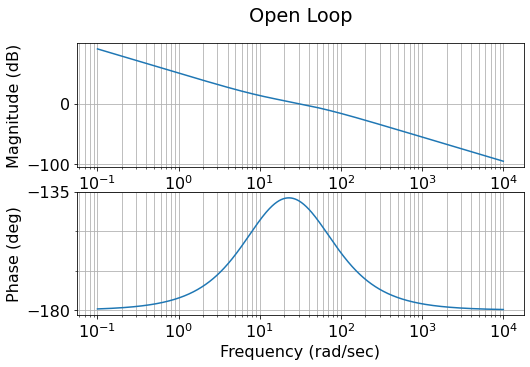

Phase margin=     41.32deg
Gain crossover frequency=     30.86rad/s


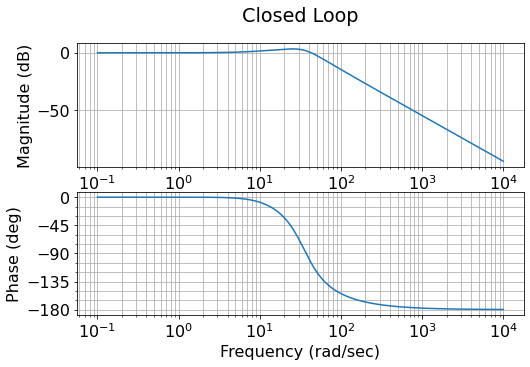

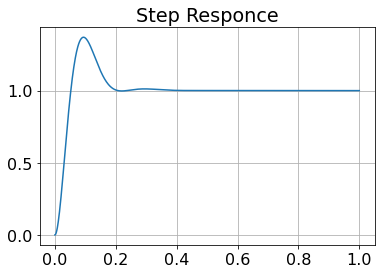

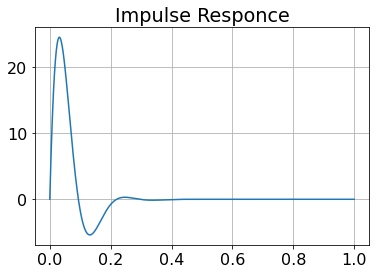

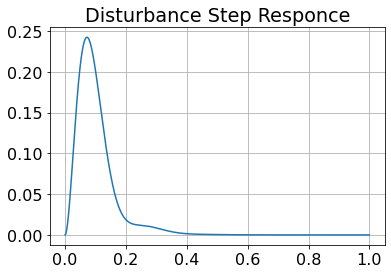

In [6]:
#PI制御
Kp=3.75
Ti=0.1

cont=matlab.tf([Kp, Kp/Ti],[1,0])
L=sysq*cont
closesys=matlab.feedback(L)

#制御対象と制御器のボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(sysq,wfreq,label='Copter')
magc,phadec,omegac = matlab.bode(cont,wfreq,label='Controller')
plt.title("Multicopter and Controller",pad=170)
plt.legend()
plt.show()

#開ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(L,wfreq,label='openloop')
plt.title("Open Loop",pad=170)
plt.show()


#位相余裕（ゲイン余裕）
gm, pm, wpc, wgc=matlab.margin(L)
print('Phase margin={:10.2f}deg\nGain crossover frequency={:10.2f}rad/s'.format(pm, wgc))


#閉ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(closesys,wfreq,label='closeloop')
plt.title("Closed Loop", pad=170)
plt.show()

#ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(closesys, t)
plt.plot(t,y)
plt.grid()
plt.title('Step Responce')
plt.show()

#インパルス応答
t=np.linspace(0,1,1000)
y,t=matlab.impulse(closesys, t)
plt.plot(t,y)
plt.grid()
plt.title('Impulse Responce')
plt.show()

###外乱応答
sys_dist=sysq/(1+cont*sysq)

#外乱ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(sys_dist, t)
plt.plot(t,y)
plt.grid()
plt.title('Disturbance Step Responce')
plt.show()

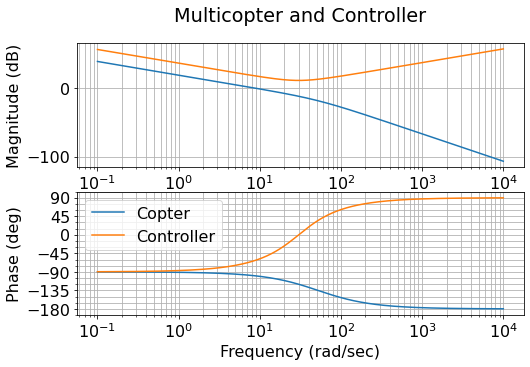

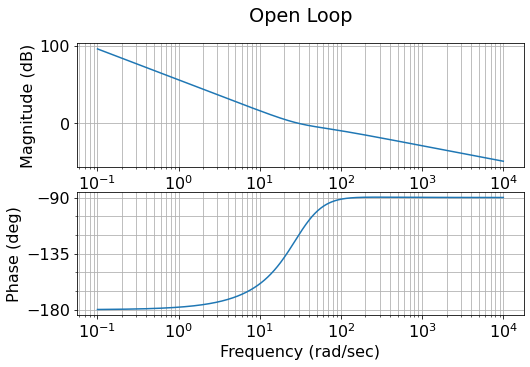

Phase margin=     59.13deg
Gain crossover frequency=     29.66rad/s


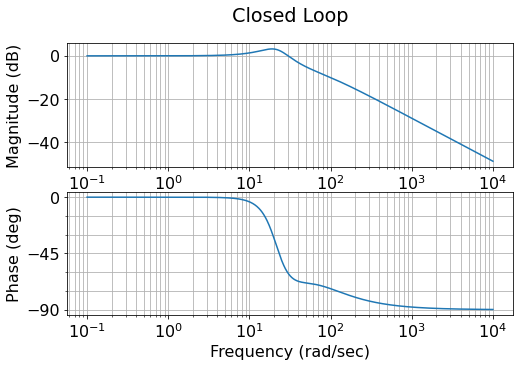

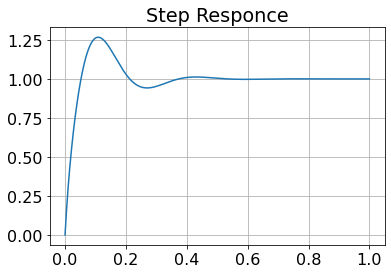

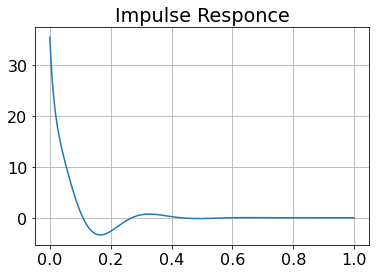

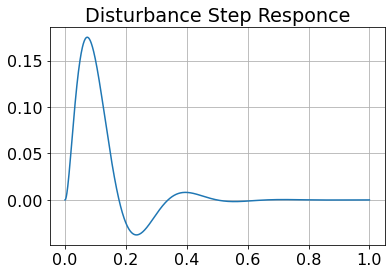

In [7]:
#PID制御
Kp=3.75
Ti=0.055
Td=0.02

cont=matlab.tf([Kp*Td, Kp, Kp/Ti],[1,0])
L=sysq*cont
closesys=matlab.feedback(L)

#制御対象と制御器のボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(sysq,wfreq,label='Copter')
magc,phadec,omegac = matlab.bode(cont,wfreq,label='Controller')
plt.title("Multicopter and Controller",pad=170)
plt.legend()
plt.show()

#開ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(L,wfreq,label='openloop')
plt.title("Open Loop",pad=170)
plt.show()


#位相余裕（ゲイン余裕）
gm, pm, wpc, wgc=matlab.margin(L)
print('Phase margin={:10.2f}deg\nGain crossover frequency={:10.2f}rad/s'.format(pm, wgc))


#閉ループボード線図
plt.figure(figsize=(8,5))
plt.rcParams["font.size"] = 16
wfreq=np.logspace(-1,4,1000)
magq,phadeq,omegaq = matlab.bode(closesys,wfreq,label='closeloop')
plt.title("Closed Loop", pad=170)
plt.show()

#ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(closesys, t)
plt.plot(t,y)
plt.grid()
plt.title('Step Responce')
plt.show()

#インパルス応答
t=np.linspace(0,1,1000)
y,t=matlab.impulse(closesys, t)
plt.plot(t,y)
plt.grid()
plt.title('Impulse Responce')
plt.show()

###外乱応答
sys_dist=sysq/(1+cont*sysq)

#外乱ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(sys_dist, t)
plt.plot(t,y)
plt.grid()
plt.title('Disturbance Step Responce')
plt.show()

Phase margin=     64.58deg
Gain crossover frequency=     24.68rad/s


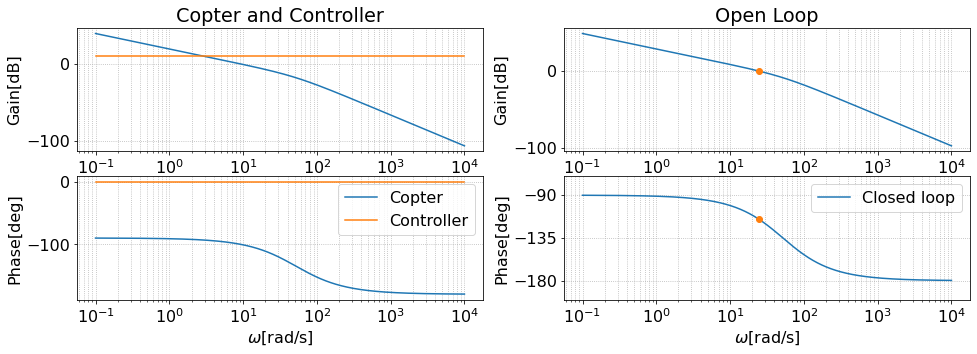

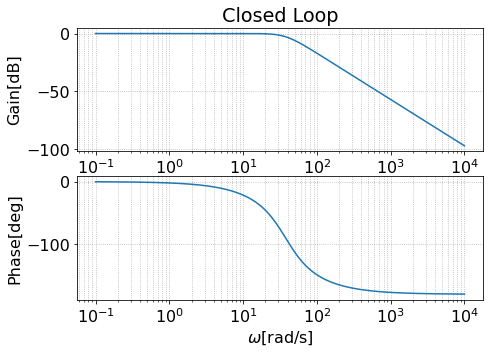

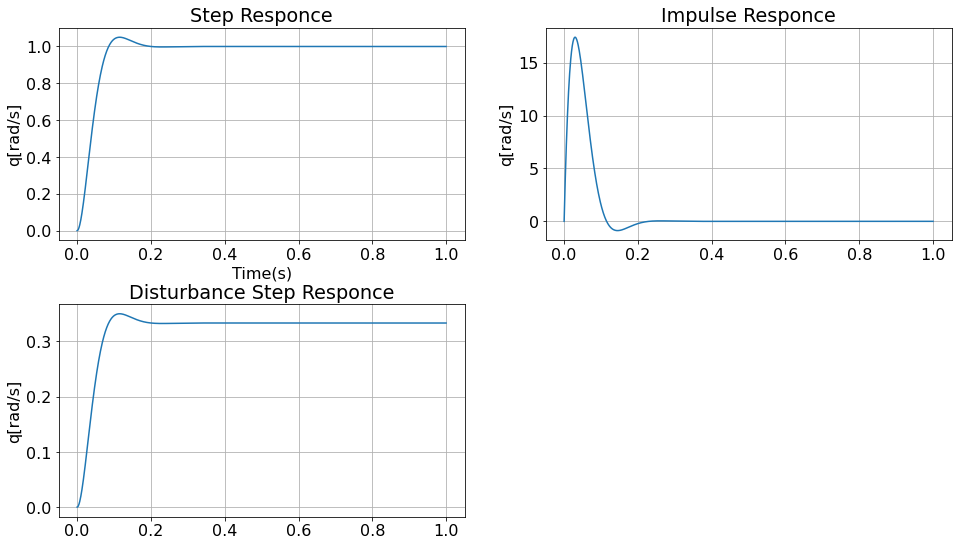

In [8]:
#比例制御 Ver 2
Kp=3.0
cont=matlab.tf([Kp],[0,1])
L=sysq*cont
closesys=matlab.feedback(L)

#位相余裕（ゲイン余裕）
gm, pm, wpc, wgc=matlab.margin(L)
print('Phase margin={:10.2f}deg\nGain crossover frequency={:10.2f}rad/s'.format(pm, wgc))

fig=plt.figure(figsize=(16,5))
wfreq=np.logspace(-1,4,1000)

#制御対象と制御器のボード線図
magq,phaseq,omegaq = matlab.bode(sysq,wfreq, plot=False)
magc,phasec,omegac = matlab.bode(cont,wfreq,plot=False)

ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,3)
ax3=fig.add_subplot(2,2,2)
ax4=fig.add_subplot(2,2,4)

ax1.grid(which="both",ls=':')
ax1.set_ylabel('Gain[dB]')
ax1.set_title('Copter and Controller')

ax2.grid(which="both",ls=':')
ax2.set_xlabel('$\omega$[rad/s]')
ax2.set_ylabel('Phase[deg]')

ax3.grid(which="both",ls=':')
ax3.set_ylabel('Gain[dB]')
ax3.set_title('Open Loop')
   
ax4.grid(which="both",ls=':')
ax4.set_xlabel('$\omega$[rad/s]')
ax4.set_ylabel('Phase[deg]')

ax1.semilogx(omegaq,20*np.log10(magq))
ax1.semilogx(omegac,20*np.log10(magc))

ax2.semilogx(omegaq,phaseq*180/np.pi,label='Copter')
ax2.semilogx(omegac,phasec*180/np.pi,label='Controller')
ax2.legend()

#開ループボード線図
magq,phaseq,omegaq = matlab.bode(L,wfreq,plot=False)
ax3.semilogx(omegaq,20*np.log10(magq))
ax3.semilogx(wgc,20*np.log10(1),marker='o')

ax4.semilogx(omegaq,phaseq*180/np.pi,label='Closed loop')
ax4.semilogx(wgc,pm-180,marker='o')
ax4.set_ylim(-200,-70)
ax4.set_yticks([-180,-135,-90])
ax4.legend()
plt.show()


fig2=plt.figure(figsize=(16,5))
#plt.rcParams["font.size"] = 16
ax5=fig2.add_subplot(221)
ax6=fig2.add_subplot(223)

#閉ループボード線図
wfreq=np.logspace(-1,4,1000)
magq,phaseq,omegaq = matlab.bode(closesys,wfreq,plot=False)
ax5.semilogx(omegaq,20*np.log10(magq))
ax6.semilogx(omegaq,phaseq*180/np.pi)

ax5.grid(which="both",ls=':')
ax5.set_ylabel('Gain[dB]')
ax5.set_title('Closed Loop')
   
ax6.grid(which="both",ls=':')
ax6.set_xlabel('$\omega$[rad/s]')
ax6.set_ylabel('Phase[deg]')
plt.show()


fig3=plt.figure(figsize=(16,9))
fig3.subplots_adjust(hspace=0.3)
ax7=fig3.add_subplot(2,2,1)
ax8=fig3.add_subplot(2,2,2)
ax9=fig3.add_subplot(2,2,3)

#ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(closesys, t)
ax7.plot(t,y)
ax7.grid()
ax7.set_xlabel('Time(s)')
ax7.set_ylabel('q[rad/s]')
ax7.set_title('Step Responce')


#インパルス応答
t=np.linspace(0,1,1000)
y,t=matlab.impulse(closesys, t)
ax8.plot(t,y)
ax8.grid()
ax8.set_ylabel('q[rad/s]')
ax8.set_title('Impulse Responce')


###外乱応答
sys_dist=sysq/(1+cont*sysq)

#外乱ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(sys_dist, t)
ax9.plot(t,y)
ax9.grid()
ax9.set_ylabel('q[rad/s]')
ax9.set_title('Disturbance Step Responce')
plt.show()

Gain crossover frequency= 13.93rad/s
Phase margin= 60.03deg


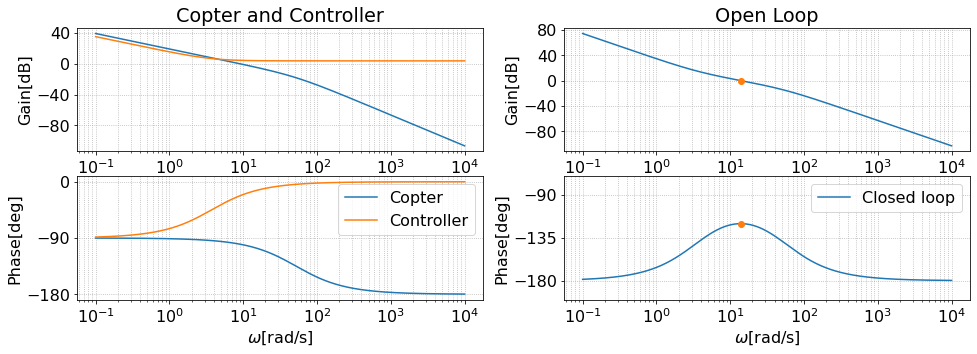

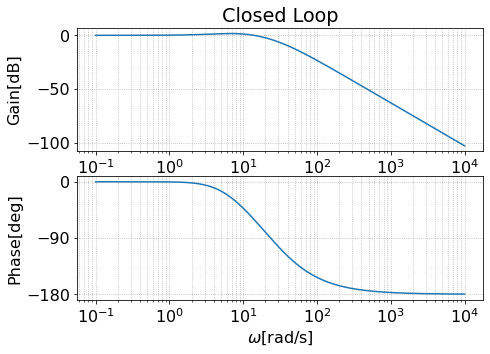

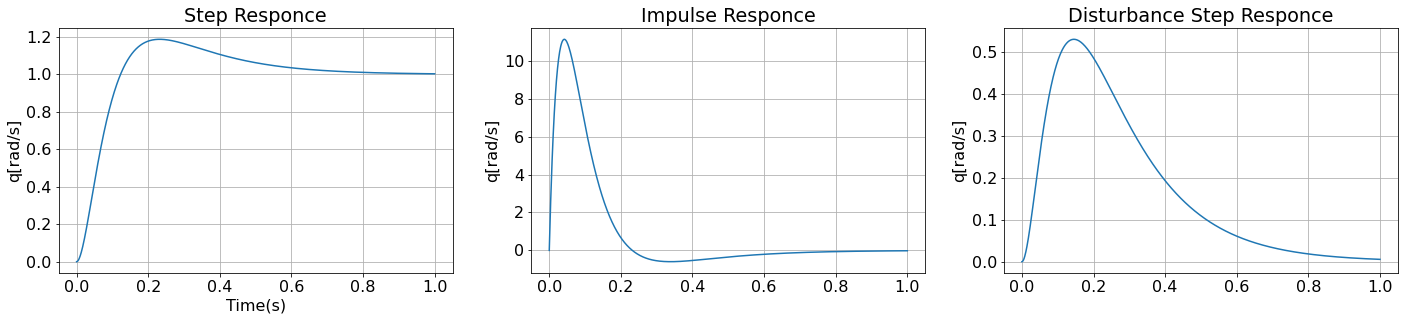

In [9]:
#PI制御 Ver 2
Kp=1.53#3.75
Ti=0.2688
cont=matlab.tf([Kp, Kp/Ti],[1,0])
L=sysq*cont
closesys=matlab.feedback(L)

#位相余裕（ゲイン余裕）
gm, pm, wpc, wgc=matlab.margin(L)
print('Gain crossover frequency={:6.2f}rad/s'.format(wgc))
print('Phase margin={:6.2f}deg'.format(pm))

fig=plt.figure(figsize=(16,5))
wfreq=np.logspace(-1,4,1000)

#制御対象と制御器のボード線図
magq,phaseq,omegaq = matlab.bode(sysq,wfreq, plot=False)
magc,phasec,omegac = matlab.bode(cont,wfreq,plot=False)

ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,3)
ax3=fig.add_subplot(2,2,2)
ax4=fig.add_subplot(2,2,4)

ax1.grid(which="both",ls=':')
ax1.set_ylabel('Gain[dB]')
ax1.set_yticks(np.arange(-80,41,40))
ax1.set_title('Copter and Controller')

ax2.grid(which="both",ls=':')
ax2.set_xlabel('$\omega$[rad/s]')
ax2.set_ylabel('Phase[deg]')
ax2.set_yticks([-180,-90,0])

ax3.grid(which="both",ls=':')
ax3.set_ylabel('Gain[dB]')
ax3.set_yticks(np.arange(-80,81,40))
ax3.set_title('Open Loop')
   
ax4.grid(which="both",ls=':')
ax4.set_xlabel('$\omega$[rad/s]')
ax4.set_ylabel('Phase[deg]')

ax1.semilogx(omegaq,20*np.log10(magq))
ax1.semilogx(omegac,20*np.log10(magc))

ax2.semilogx(omegaq,phaseq*180/np.pi,label='Copter')
ax2.semilogx(omegac,phasec*180/np.pi,label='Controller')
ax2.legend()

#開ループボード線図
magq,phaseq,omegaq = matlab.bode(L,wfreq,plot=False)
ax3.semilogx(omegaq,20*np.log10(magq))
ax3.semilogx(wgc,20*np.log10(1),marker='o')

ax4.semilogx(omegaq,phaseq*180/np.pi,label='Closed loop')
ax4.semilogx(wgc,pm-180,marker='o')
ax4.set_ylim(-200,-70)
ax4.set_yticks([-180,-135,-90])
ax4.legend()
plt.show()


fig2=plt.figure(figsize=(16,5))
#plt.rcParams["font.size"] = 16
ax5=fig2.add_subplot(221)
ax6=fig2.add_subplot(223)

#閉ループボード線図
wfreq=np.logspace(-1,4,1000)
magq,phaseq,omegaq = matlab.bode(closesys,wfreq,plot=False)
ax5.semilogx(omegaq,20*np.log10(magq))
ax6.semilogx(omegaq,phaseq*180/np.pi)

ax5.grid(which="both",ls=':')
ax5.set_ylabel('Gain[dB]')
ax5.set_title('Closed Loop')
   
ax6.grid(which="both",ls=':')
ax6.set_xlabel('$\omega$[rad/s]')
ax6.set_ylabel('Phase[deg]')
ax6.set_yticks([-180,-90,0])
plt.show()


fig3=plt.figure(figsize=(24,4.5))
fig3.subplots_adjust(hspace=0.3)
ax7=fig3.add_subplot(1,3,1)
ax8=fig3.add_subplot(1,3,2)
ax9=fig3.add_subplot(1,3,3)

#ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(closesys, t)
ax7.plot(t,y)
ax7.grid()
ax7.set_xlabel('Time(s)')
ax7.set_ylabel('q[rad/s]')
ax7.set_title('Step Responce')


#インパルス応答
t=np.linspace(0,1,1000)
y,t=matlab.impulse(closesys, t)
ax8.plot(t,y)
ax8.grid()
ax8.set_ylabel('q[rad/s]')
ax8.set_title('Impulse Responce')


###外乱応答
sys_dist=sysq/(1+cont*sysq)

#外乱ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(sys_dist, t)
ax9.plot(t,y)
ax9.grid()
ax9.set_ylabel('q[rad/s]')
ax9.set_title('Disturbance Step Responce')
plt.show()

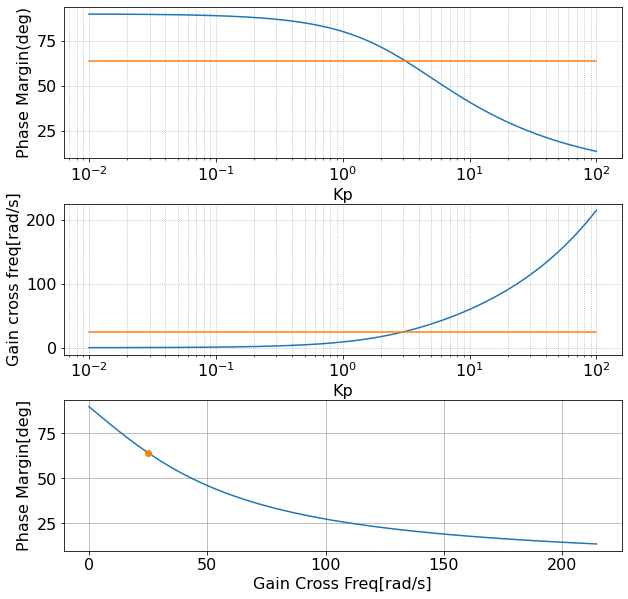

In [10]:
#P制御設計ツール 比例ゲインvsゲイン余裕と位相余裕

#設計仕様
gcd=25.0
pmd=64.0

#比例ゲイン範囲
Kps=np.logspace(-2,2,100)

#メイン
WGC=[]
PM=[]

for Kp in Kps:
    cont=Kp#matlab.tf([Kp, Kp/Ti],[1,0])
    L=sysq*cont
    #位相余裕（ゲイン余裕）
    gm, pm, wpc, wgc=matlab.margin(L)
    #print(Kp, Ti, wgc, pm)
    WGC.append(wgc)
    PM.append(pm)

WGC=np.array(WGC)
PM=np.array(PM)

fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.3)
ax1=fig.add_subplot(311)
ax1.semilogx(Kps,PM)
ax1.semilogx([Kps[0],Kps[-1]],[pmd,pmd])
ax1.grid(which="both",ls=':')
ax1.set_xlabel('Kp')
#ax1.yticks([-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100])
ax1.set_ylabel('Phase Margin(deg)')

ax2=fig.add_subplot(312)
ax2.semilogx(Kps,WGC)
ax2.semilogx([Kps[0],Kps[-1]],[gcd,gcd])
ax2.grid(which="both",ls=':')
ax2.set_xlabel('Kp')
ax2.set_ylabel('Gain cross freq[rad/s]')

ax3=fig.add_subplot(313)
plt.plot(WGC,PM)
plt.plot(gcd, pmd, marker='o')
ax3.grid()
ax3.set_xlabel('Gain Cross Freq[rad/s]')
ax3.set_ylabel('Phase Margin[deg]')
plt.show()

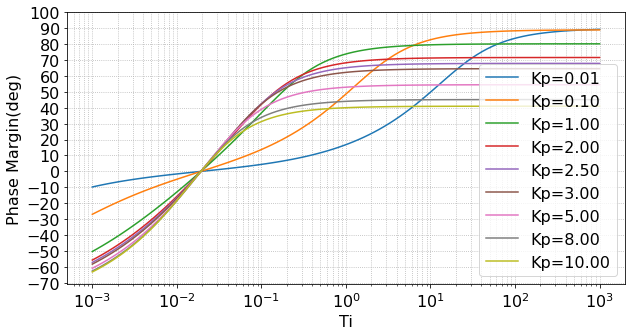

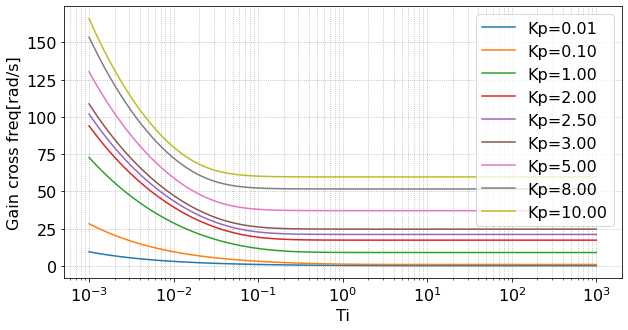

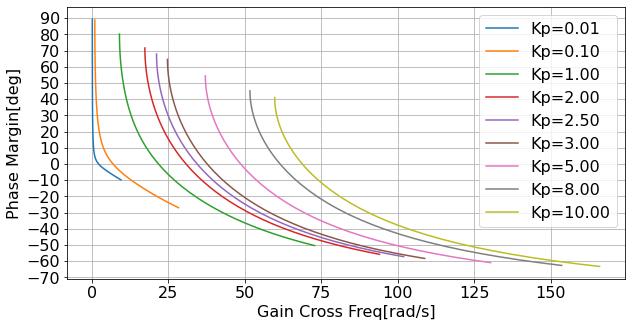

In [11]:
#PI制御 設計ツール　Ver.１ ゲイン余裕と位相余裕
#こちらよりVer２が良い

Tis=np.logspace(-3,3,100)

WGCS=[]
PMS=[]
Kps=[0.01,0.1,1,2,2.5,3,5,8,10]

for Kp in Kps:
    WGC=[]
    PM=[]

    for Ti in Tis: 
        cont=matlab.tf([Kp, Kp/Ti],[1,0])
        L=sysq*cont

        #位相余裕（ゲイン余裕）
        gm, pm, wpc, wgc=matlab.margin(L)
        #print(Kp, Ti, wgc, pm)
        WGC.append(wgc)
        PM.append(pm)

    WGC=np.array(WGC)
    PM=np.array(PM)

    WGCS.append(WGC)
    PMS.append(PM)

plt.figure(figsize=(10,5))
for PM,Kp in zip(PMS,Kps):
    plt.semilogx(Tis,PM, label='Kp={:4.2f}'.format(Kp))

plt.grid(which="both",ls=':')
plt.xlabel('Ti')
plt.yticks([-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Phase Margin(deg)')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for WGC,Kp in zip(WGCS,Kps):
    plt.semilogx(Tis,WGC,  label='Kp={:4.2f}'.format(Kp))
plt.grid(which="both",ls=':')
plt.xlabel('Ti')
plt.ylabel('Gain cross freq[rad/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for WGC,PM,Kp in zip(WGCS,PMS,Kps):
    plt.plot(WGC,PM, label='Kp={:4.2f}'.format(Kp))
plt.grid()
plt.yticks(range(-70,91,10))
plt.xlabel('Gain Cross Freq[rad/s]')
plt.ylabel('Phase Margin[deg]')
plt.legend()
plt.show()

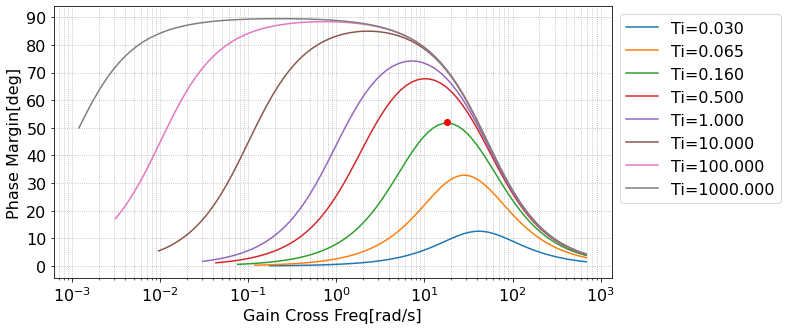

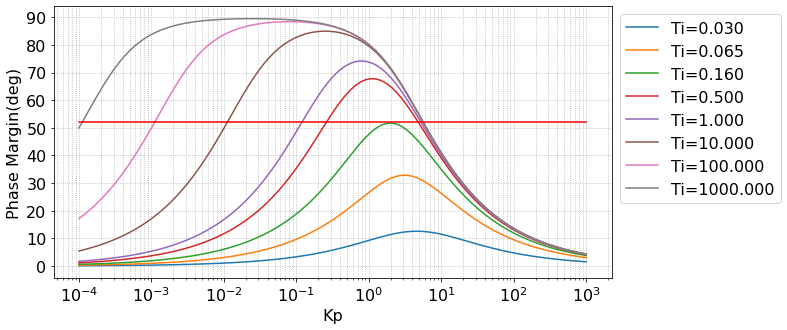

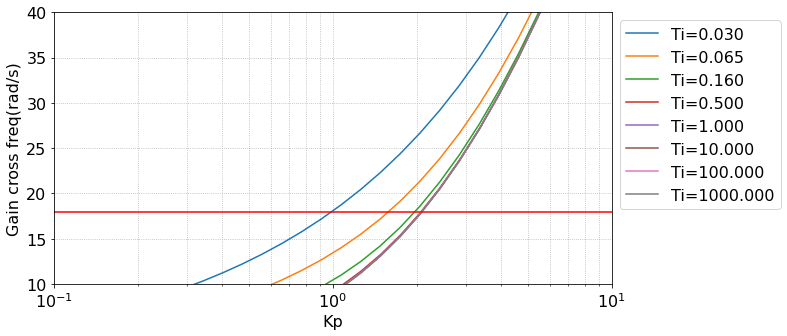

In [12]:
#PI制御 設計ツール　Ver 2.0

#設計仕様
gcd=18.
pmd=52.0

#積分時間候補リスト
Tis=[0.03,0.065,0.16,0.5,1,10,100,1000]

#微分ゲイン範囲
Kps=np.logspace(-4,3,100)

#メイン
WGCS=[]
PMS=[]

for Ti in Tis:
    WGC=[]
    PM=[]

    for Kp in Kps: 
        cont=matlab.tf([Kp, Kp/Ti],[1,0])
        L=sysq*cont

        #位相余裕（ゲイン余裕）
        gm, pm, wpc, wgc=matlab.margin(L)
        #print(Kp, Ti, wgc, pm)
        WGC.append(wgc)
        PM.append(pm)

    WGC=np.array(WGC)
    PM=np.array(PM)

    WGCS.append(WGC)
    PMS.append(PM)

    
plt.figure(figsize=(10,5))
for WGC,PM,Ti in zip(WGCS,PMS,Tis):
    plt.semilogx(WGC,PM, label='Ti={:5.3f}'.format(Ti))
plt.semilogx(gcd,pmd,marker='o',c='r')
plt.grid(which="both",ls=':')
plt.yticks(range(0,91,10))
plt.xlabel('Gain Cross Freq[rad/s]')
plt.ylabel('Phase Margin[deg]')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()
    
plt.figure(figsize=(10,5))
for PM,Ti in zip(PMS,Tis):
    plt.semilogx(Kps,PM, label='Ti={:5.3f}'.format(Ti))
plt.semilogx([Kps[0],Kps[-1]],[pmd, pmd],c='r')
    
plt.grid(which="both",ls=':')
plt.xlabel('Kp')
plt.yticks(range(0,91,10))
plt.ylabel('Phase Margin(deg)')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
for WGC,Ti in zip(WGCS,Tis):
    plt.semilogx(Kps,WGC,  label='Ti={:5.3f}'.format(Ti))
plt.semilogx([Kps[0],Kps[-1]],[gcd, gcd],c='r')
plt.grid(which="both",ls=':')
plt.xlabel('Kp')
plt.ylabel('Gain cross freq(rad/s)')
plt.xlim(0.1,10)
plt.ylim(10,40)
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()



  0%|          | 0/50 [00:00<?, ?it/s]

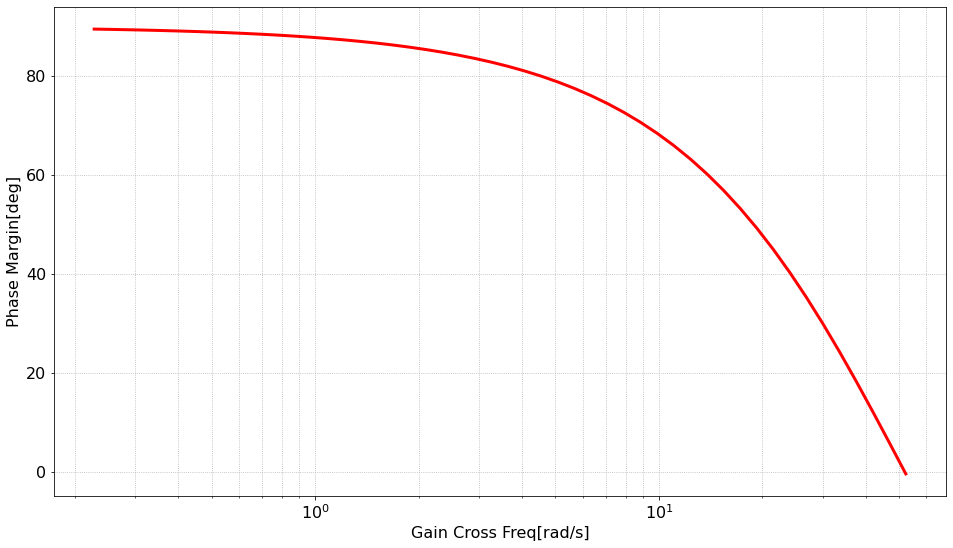

PM=60.00
Gc=13.91
Kp= 1.53
Ti=  0.2688


In [13]:
#PI制御 位相余裕最適値探索　
from tqdm.notebook import tqdm_notebook as tqdm

def df(kp):
    h=1e-5
    cont1=matlab.tf([kp, kp/Ti],[1,0])
    L1=sysq*cont1
    gm1, pm1, wpc1, wgc1=matlab.margin(L1)

    cont2=matlab.tf([kp+h, (kp+h)/Ti],[1,0])
    L2=sysq*cont2
    gm2, pm2, wpc2, wgc2=matlab.margin(L2)

    return (pm2-pm1)/h

#設計仕様
gcd=18.
pmd=52.0

#積分時間候補リスト
#Tis=[0.03,0.065,0.16,0.5,1,10,100,1000]
Tis=np.logspace(np.log10(0.019),np.log10(1000),50)

#メイン
WGCP=[]
PMP=[]
KPS=[]
eps=1e-5
h=0.001

for Ti in tqdm(Tis):
    Kp1=0.01
    Kp2=1000
    counter=0
    
    while (Kp2-Kp1>eps): 
        Kpm=(Kp1+Kp2)/2
        pmm=df(Kpm)
        pm1=df(Kp1)
        pm2=df(Kp2)
        if pmm*pm1>0.0:
            Kp1=Kpm
        else:
            Kp2=Kpm
        counter+=1
        #print(Kpm,pmm)    
    
    Kpm=(Kp1+Kp2)/2
    contm=matlab.tf([Kpm, Kpm/Ti],[1,0])
    Lm=sysq*contm
    gmm, pmm, wpcm, wgcm=matlab.margin(Lm)

    KPS.append(Kpm)
    WGCP.append(wgcm)
    PMP.append(pmm)
    #print(counter,wgcm,pmm)
    #print()

    
#print(WGC,PM)
plt.figure(figsize=(16,9))
plt.semilogx(WGCP,PMP,c='r',lw=3)
plt.grid(which="both",ls=':')
#plt.yticks(range(0,91,10))
plt.xlabel('Gain Cross Freq[rad/s]')
plt.ylabel('Phase Margin[deg]')
#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()



wgcp=np.array(WGCP)
pmp=np.array(PMP)
kps=np.array(KPS)
tis=np.array(Tis)

pmde=60
gcde=np.interp(pmde,pmp,wgcp)
kpde=np.interp(pmde,pmp,kps)
tide=np.interp(kpde,kps[::-1],tis[::-1])
print('PM={:5.2f}'.format(pmde))

print('Gc={:5.2f}'.format(gcde))
print('Kp={:5.2f}'.format(kpde))
print('Ti={:8.4f}'.format(tide))








  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

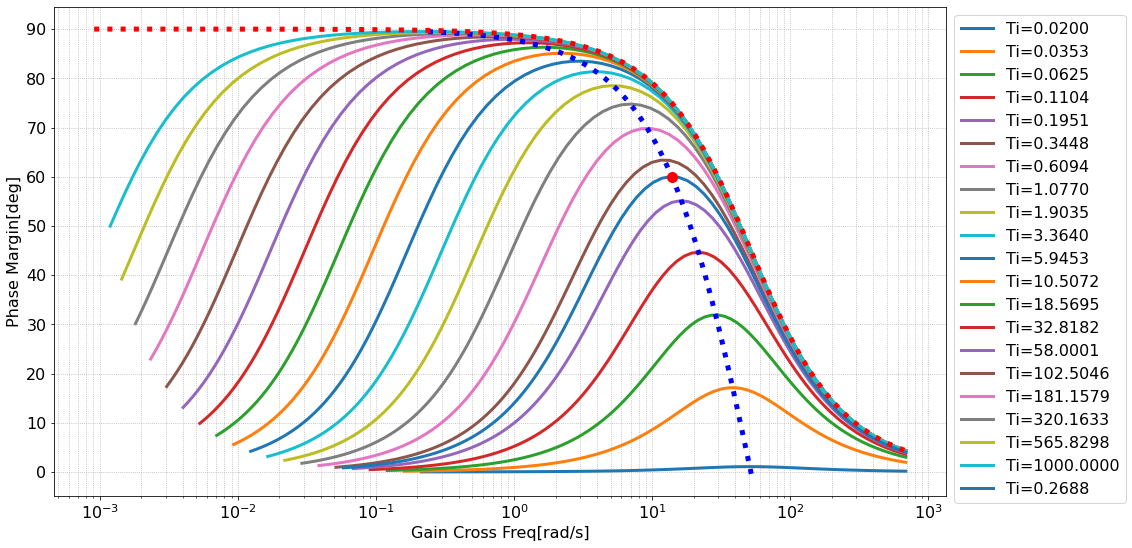

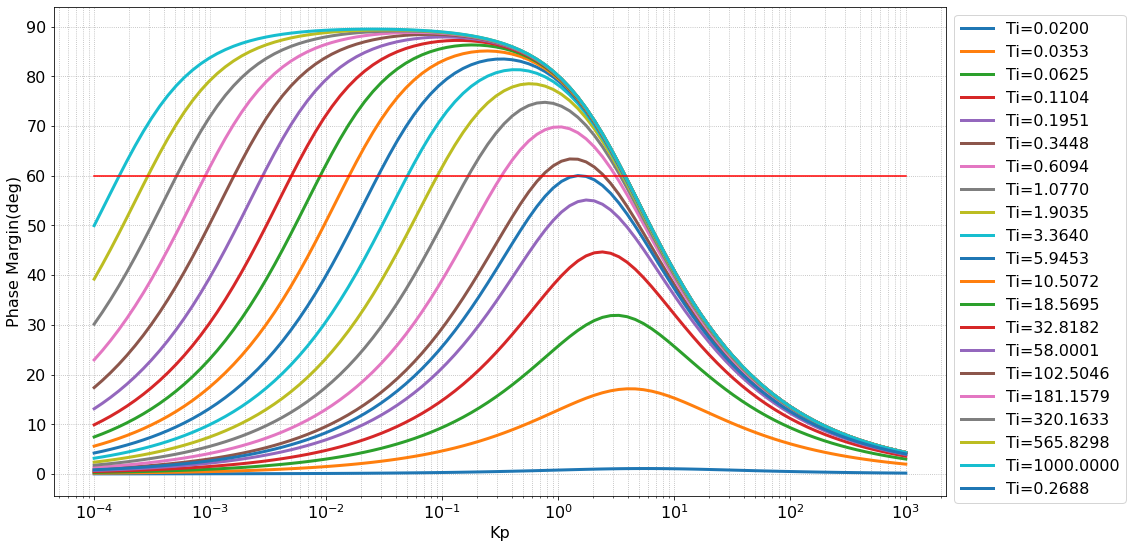

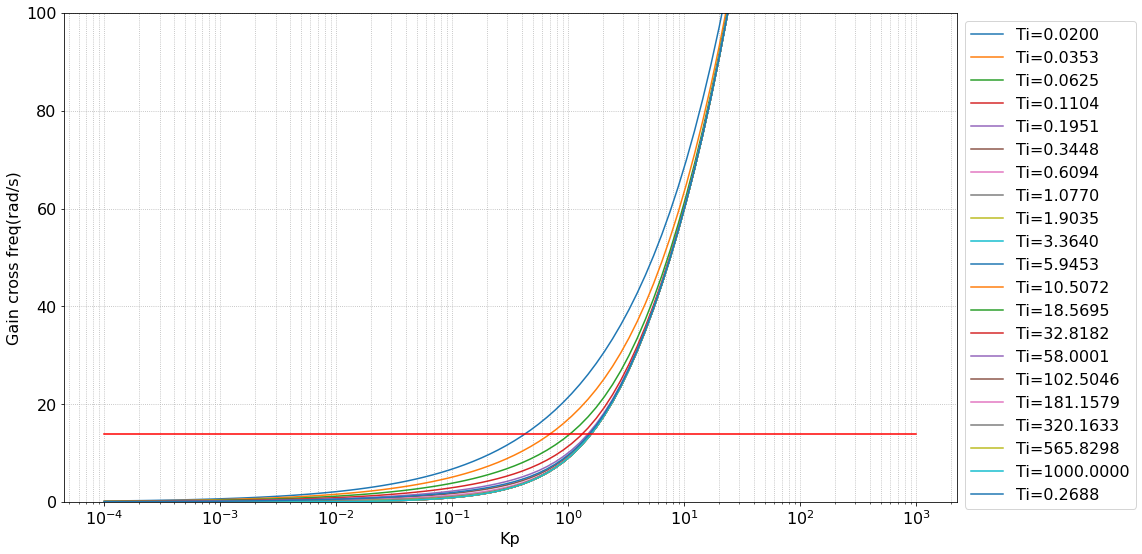

In [14]:
#PI制御 設計ツール　Ver 2.0

#設計仕様
gcd=13.91
pmd=60

#積分時間候補リスト
#Tis=[0.03,0.065,0.16,0.5,1,10,100,1000]
Tis=np.logspace(np.log10(0.02),np.log10(1000),20)
Tis=np.append(Tis,0.2688)


#微分ゲイン範囲
Kps=np.logspace(-4,3,100)

#メイン
WGCS=[]
PMS=[]

for Ti in tqdm(Tis):
    WGC=[]
    PM=[]

    for Kp in Kps: 
        cont=matlab.tf([Kp, Kp/Ti],[1,0])
        L=sysq*cont

        #位相余裕（ゲイン余裕）
        gm, pm, wpc, wgc=matlab.margin(L)
        #print(Kp, Ti, wgc, pm)
        WGC.append(wgc)
        PM.append(pm)

    WGC=np.array(WGC)
    PM=np.array(PM)

    WGCS.append(WGC)
    PMS.append(PM)

WGCpro=[]
PMpro=[]
for Kp in tqdm(Kps):
    cont=Kp
    L=sysq*cont
    #位相余裕（ゲイン余裕）
    gm, pm, wpc, wgc=matlab.margin(L)
    #print(Kp, Ti, wgc, pm)
    WGCpro.append(wgc)
    PMpro.append(pm)
    
    
plt.figure(figsize=(16,9))
for WGC,PM,Ti in zip(WGCS,PMS,Tis):
    plt.semilogx(WGC,PM, lw=3,label='Ti={:6.4f}'.format(Ti))
plt.semilogx(WGCP,PMP,c='b',lw=5, ls=':')
plt.semilogx(WGCpro,PMpro,c='r',lw=5, ls=':')

plt.semilogx(gcd,pmd,marker='o',c='r',ms=10)
plt.grid(which="both",ls=':')
plt.yticks(range(0,91,10))
plt.xlabel('Gain Cross Freq[rad/s]')
plt.ylabel('Phase Margin[deg]')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()


plt.figure(figsize=(16,9))
for PM,Ti in zip(PMS,Tis):
    plt.semilogx(Kps,PM, lw=3,label='Ti={:6.4f}'.format(Ti))
plt.semilogx([Kps[0],Kps[-1]],[pmd, pmd],c='r')
    
plt.grid(which="both",ls=':')
plt.xlabel('Kp')
plt.yticks(range(0,91,10))
plt.ylabel('Phase Margin(deg)')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

plt.figure(figsize=(16,9))
for WGC,Ti in zip(WGCS,Tis):
    plt.semilogx(Kps,WGC,  label='Ti={:6.4f}'.format(Ti))
plt.semilogx([Kps[0],Kps[-1]],[gcd, gcd],c='r')
plt.grid(which="both",ls=':')
plt.xlabel('Kp')
plt.ylabel('Gain cross freq(rad/s)')
#plt.xlim(0.1,10)
plt.ylim(0,100)
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()




PM=30.00
Gc=29.98
Kp= 3.29
Ti=  0.0578


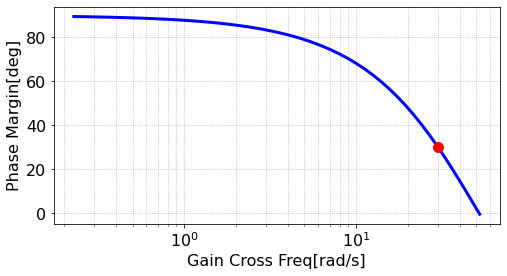

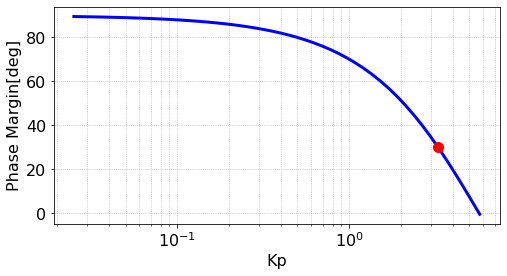

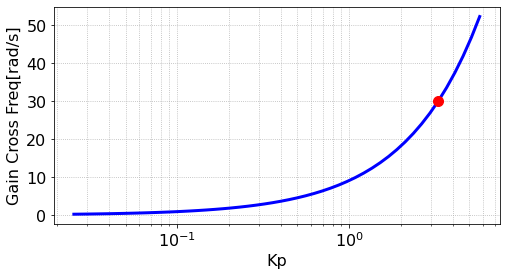

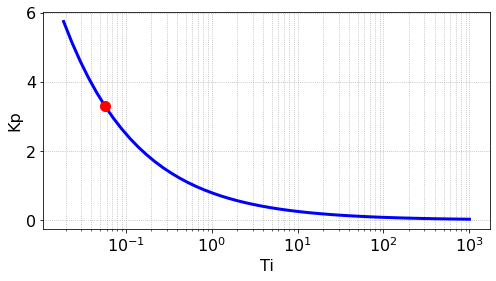

In [15]:
#積分時間候補リスト
#Tis=[0.03,0.065,0.16,0.5,1,10,100,1000]
Tis=np.logspace(np.log10(0.019),np.log10(1000),50)

wgcp=np.array(WGCP)
pmp=np.array(PMP)
kps=np.array(KPS)
tis=np.array(Tis)

pmde=30
gcde=np.interp(pmde,pmp,wgcp)
kpde=np.interp(pmde,pmp,kps)
tide=np.interp(kpde,kps[::-1],tis[::-1])
print('PM={:5.2f}'.format(pmde))

print('Gc={:5.2f}'.format(gcde))
print('Kp={:5.2f}'.format(kpde))
print('Ti={:8.4f}'.format(tide))



#wgcp=np.flipud(wgcp)
#pmp=np.flipud(pmp)
plt.figure(figsize=(8,4))
plt.semilogx(wgcp,pmp,c='b',lw=3)
plt.semilogx(gcde,pmde,marker='o',c='r',ms=10)
plt.grid(which="both",ls=':')
#plt.yticks(range(0,91,10))
plt.xlabel('Gain Cross Freq[rad/s]')
plt.ylabel('Phase Margin[deg]')
plt.show()

plt.figure(figsize=(8,4))
plt.semilogx(kps,pmp,c='b',lw=3)
plt.semilogx(kpde,pmde,marker='o',c='r',ms=10)
plt.grid(which="both",ls=':')
#plt.yticks(range(0,91,10))
plt.xlabel('Kp')
plt.ylabel('Phase Margin[deg]')
plt.show()

plt.figure(figsize=(8,4))
plt.semilogx(kps,wgcp,c='b',lw=3)
plt.semilogx(kpde,gcde,marker='o',c='r',ms=10)

plt.grid(which="both",ls=':')
#plt.yticks(range(0,91,10))
plt.xlabel('Kp')
plt.ylabel('Gain Cross Freq[rad/s]')
plt.show()

plt.figure(figsize=(8,4))
plt.semilogx(tis,kps,c='b',lw=3)
plt.semilogx(tide,kpde,marker='o',c='r',ms=10)

plt.grid(which="both",ls=':')
#plt.yticks(range(0,91,10))
plt.xlabel('Ti')
plt.ylabel('Kp')
plt.show()






Gain crossover frequency= 29.97rad/s
Phase margin= 30.01deg

Gain crossover frequency= 24.22rad/s
Phase margin= 40.03deg

Gain crossover frequency= 18.93rad/s
Phase margin= 50.09deg

Gain crossover frequency= 13.93rad/s
Phase margin= 60.03deg



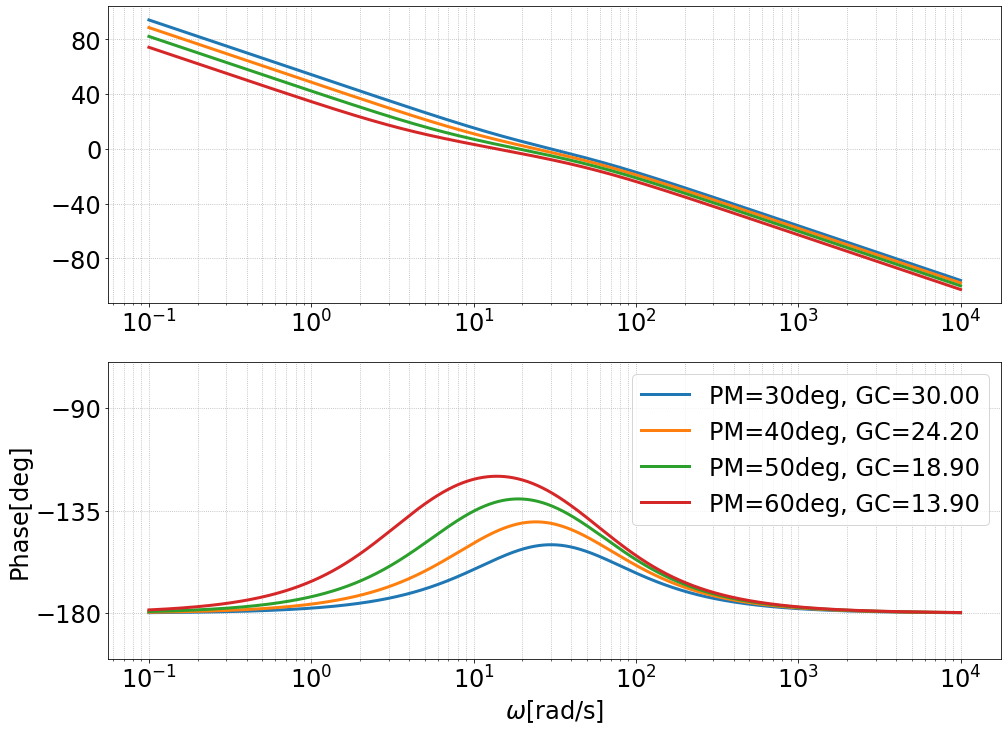

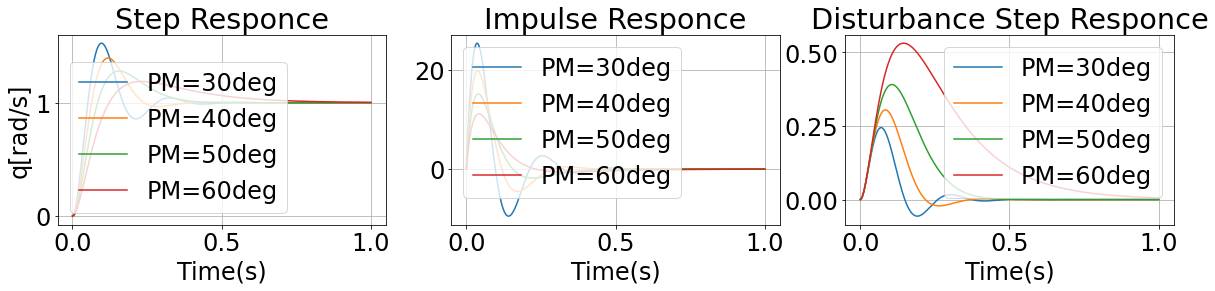

In [16]:
#PI制御 Ver 2
PMs=[30,40,50,60]
GCs=[30,24.2,18.9,13.9]
Kps=[3.29,2.66,2.08,1.53]
Tis=[0.0578,0.0887,0.1461,0.2688]

#Kp=Kps[0]
#Ti=Tis[0]

plt.rcParams["font.size"] = 24

fig=plt.figure(figsize=(16,12))

fig3=plt.figure(figsize=(20,3.5))
fig3.subplots_adjust(hspace=0.3)

ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax1.grid(which="both",ls=':')
ax1.set_yticks(np.arange(-80,81,40))

ax2.grid(which="both",ls=':')
ax2.set_ylim(-200,-70)
ax2.set_yticks([-180,-135,-90])
ax2.set_ylabel('Phase[deg]')
ax2.set_xlabel('$\omega$[rad/s]')

ax7=fig3.add_subplot(1,3,1)
ax8=fig3.add_subplot(1,3,2)
ax9=fig3.add_subplot(1,3,3)


ax7.grid()

ax7.set_xlabel('Time(s)')
ax7.set_ylabel('q[rad/s]')
ax7.set_title('Step Responce')
ax8.grid()

ax8.set_xlabel('Time(s)')
ax8.set_title('Impulse Responce')
ax9.grid()

ax9.set_xlabel('Time(s)')
ax9.set_title('Disturbance Step Responce')



for Kp,Ti,pm,gc in zip(Kps,Tis,PMs,GCs):
    cont=matlab.tf([Kp, Kp/Ti],[1,0])
    L=sysq*cont
    closesys=matlab.feedback(L)

    #位相余裕（ゲイン余裕）
    gm, pm, wpc, wgc=matlab.margin(L)
    print('Gain crossover frequency={:6.2f}rad/s'.format(wgc))
    print('Phase margin={:6.2f}deg\n'.format(pm))

    wfreq=np.logspace(-1,4,1000)

    #制御対象と制御器のボード線図
    magq,phaseq,omegaq = matlab.bode(sysq,wfreq, plot=False)
    magc,phasec,omegac = matlab.bode(cont,wfreq,plot=False)


    #開ループボード線図
    magq,phaseq,omegaq = matlab.bode(L,wfreq,plot=False)
    ax1.semilogx(omegaq,20*np.log10(magq), lw=3)
    #ax1.semilogx(wgc,20*np.log10(1),marker='o')
    ax2.semilogx(omegaq,phaseq*180/np.pi,lw=3,label='PM={:d}deg, GC={:5.2f}'.format(int(pm),gc))
    #ax2.semilogx(wgc,pm-180,marker='o')

    #ステップ応答
    t=np.linspace(0,1,1000)
    y,t=matlab.step(closesys, t)
    ax7.plot(t,y,label='PM={:d}deg'.format(int(pm)))

    #インパルス応答
    y,t=matlab.impulse(closesys, t)
    ax8.plot(t,y,label='PM={:d}deg'.format(int(pm)))

    ###外乱応答
    sys_dist=sysq/(1+cont*sysq)
    #外乱ステップ応答
    y,t=matlab.step(sys_dist, t)
    ax9.plot(t,y,label='PM={:d}deg'.format(int(pm)))

ax2.legend()
ax7.legend()
ax8.legend()
ax9.legend()

plt.show()

Gain crossover frequency= 22.92rad/s
Phase margin= 51.46deg


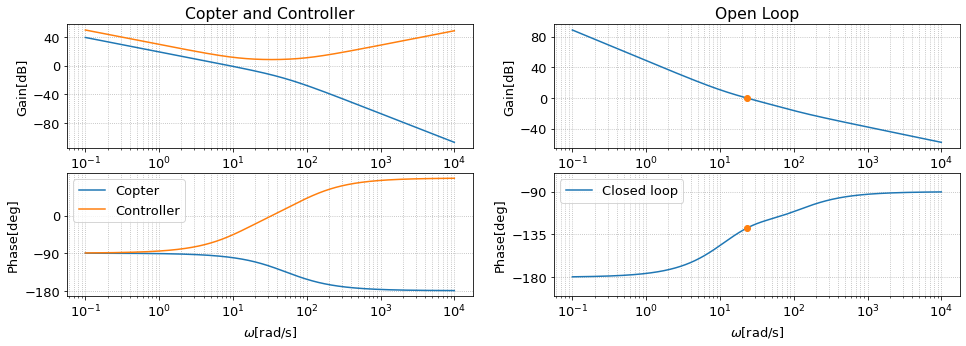

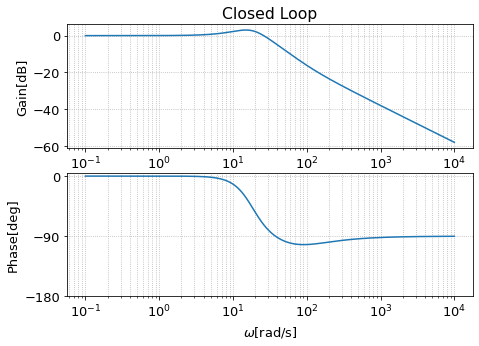

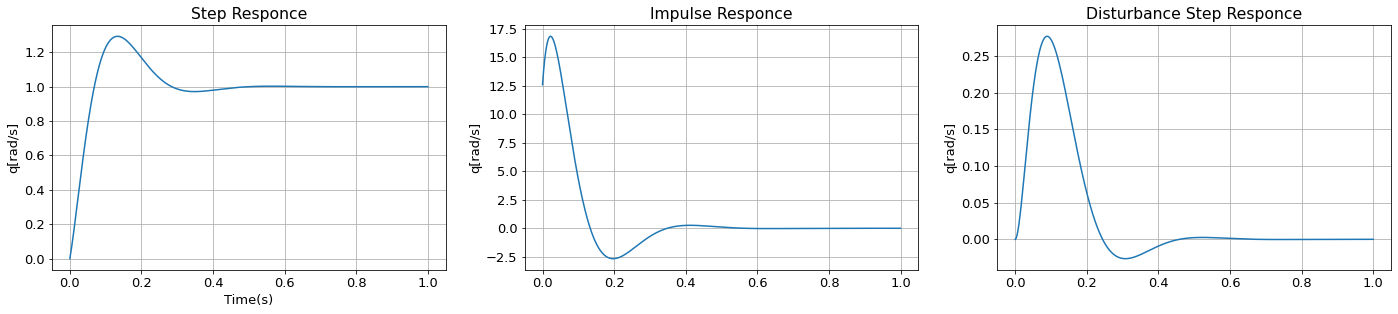

In [23]:
#PID制御 Ver 1
Kps=[3.29,2.66,2.08,1.53]
Tis=[0.0578,0.0887,0.1461,0.2688]

id=1
Kp=Kps[id]
Ti=Tis[id]
Td=0.01
cont=matlab.tf([Kp*Td, Kp, Kp/Ti],[1,0])
L=sysq*cont
closesys=matlab.feedback(L)

#位相余裕（ゲイン余裕）
gm, pm, wpc, wgc=matlab.margin(L)
print('Gain crossover frequency={:6.2f}rad/s'.format(wgc))
print('Phase margin={:6.2f}deg'.format(pm))

plt.rcParams["font.size"] = 13
fig=plt.figure(figsize=(16,5))
wfreq=np.logspace(-1,4,1000)

#制御対象と制御器のボード線図
magq,phaseq,omegaq = matlab.bode(sysq,wfreq, plot=False)
magc,phasec,omegac = matlab.bode(cont,wfreq,plot=False)

ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,3)
ax3=fig.add_subplot(2,2,2)
ax4=fig.add_subplot(2,2,4)

ax1.grid(which="both",ls=':')
ax1.set_ylabel('Gain[dB]')
ax1.set_yticks(np.arange(-80,41,40))
ax1.set_title('Copter and Controller')

ax2.grid(which="both",ls=':')
ax2.set_xlabel('$\omega$[rad/s]')
ax2.set_ylabel('Phase[deg]')
ax2.set_yticks([-180,-90,0])

ax3.grid(which="both",ls=':')
ax3.set_ylabel('Gain[dB]')
ax3.set_yticks(np.arange(-80,81,40))
ax3.set_title('Open Loop')
   
ax4.grid(which="both",ls=':')
ax4.set_xlabel('$\omega$[rad/s]')
ax4.set_ylabel('Phase[deg]')

ax1.semilogx(omegaq,20*np.log10(magq))
ax1.semilogx(omegac,20*np.log10(magc))

ax2.semilogx(omegaq,phaseq*180/np.pi,label='Copter')
ax2.semilogx(omegac,phasec*180/np.pi,label='Controller')
ax2.legend()

#開ループボード線図
magq,phaseq,omegaq = matlab.bode(L,wfreq,plot=False)
ax3.semilogx(omegaq,20*np.log10(magq))
ax3.semilogx(wgc,20*np.log10(1),marker='o')

ax4.semilogx(omegaq,phaseq*180/np.pi,label='Closed loop')
ax4.semilogx(wgc,pm-180,marker='o')
ax4.set_ylim(-200,-70)
ax4.set_yticks([-180,-135,-90])
ax4.legend()
plt.show()


fig2=plt.figure(figsize=(16,5))
ax5=fig2.add_subplot(221)
ax6=fig2.add_subplot(223)

#閉ループボード線図
wfreq=np.logspace(-1,4,1000)
magq,phaseq,omegaq = matlab.bode(closesys,wfreq,plot=False)
ax5.semilogx(omegaq,20*np.log10(magq))
ax6.semilogx(omegaq,phaseq*180/np.pi)

ax5.grid(which="both",ls=':')
ax5.set_ylabel('Gain[dB]')
ax5.set_title('Closed Loop')
   
ax6.grid(which="both",ls=':')
ax6.set_xlabel('$\omega$[rad/s]')
ax6.set_ylabel('Phase[deg]')
ax6.set_yticks([-180,-90,0])
plt.show()


fig3=plt.figure(figsize=(24,4.5))
fig3.subplots_adjust(hspace=0.3)
ax7=fig3.add_subplot(1,3,1)
ax8=fig3.add_subplot(1,3,2)
ax9=fig3.add_subplot(1,3,3)

#ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(closesys, t)
ax7.plot(t,y)
ax7.grid()
ax7.set_xlabel('Time(s)')
ax7.set_ylabel('q[rad/s]')
ax7.set_title('Step Responce')


#インパルス応答
t=np.linspace(0,1,1000)
y,t=matlab.impulse(closesys, t)
ax8.plot(t,y)
ax8.grid()
ax8.set_ylabel('q[rad/s]')
ax8.set_title('Impulse Responce')


###外乱応答
sys_dist=sysq/(1+cont*sysq)

#外乱ステップ応答
t=np.linspace(0,1,1000)
y,t=matlab.step(sys_dist, t)
ax9.plot(t,y)
ax9.grid()
ax9.set_ylabel('q[rad/s]')
ax9.set_title('Disturbance Step Responce')
plt.show()

Td=  0.0000
Gain crossover frequency= 24.22rad/s
Phase margin= 40.03deg

Td=  0.0010
Gain crossover frequency= 24.06rad/s
Phase margin= 41.17deg

Td=  0.0100
Gain crossover frequency= 22.92rad/s
Phase margin= 51.46deg

Td=  0.1000
Gain crossover frequency=113.91rad/s
Phase margin=109.44deg



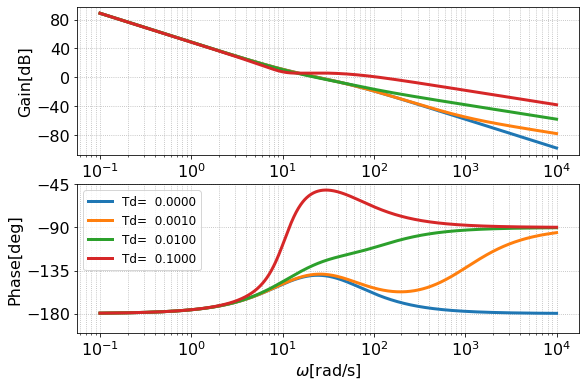

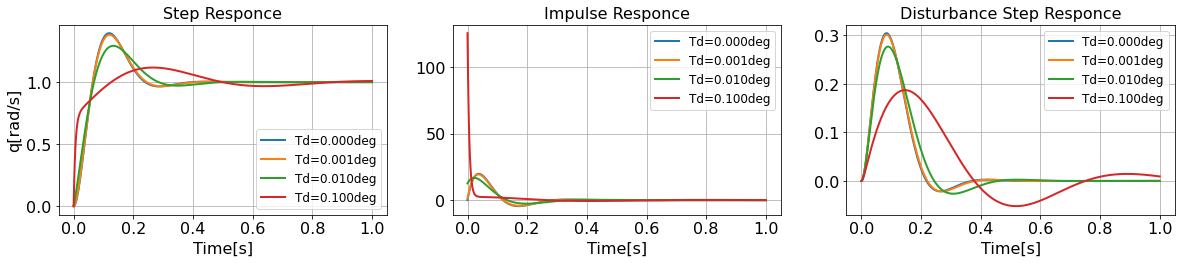

In [62]:
#PID制御 Dゲイン複数
PMs=[30,40,50,60]
GCs=[30,24.2,18.9,13.9]
Kps=[3.29,2.66,2.08,1.53]
Tis=[0.0578,0.0887,0.1461,0.2688]
Tds=[0, 0.001, 0.01, 0.1]

id=1
Kp=Kps[id]
Ti=Tis[id]

#plt.rcParams["font.size"] = 12

bodefontsize=16
timeresfontsize=16


fig=plt.figure(figsize=(9,6))
fig3=plt.figure(figsize=(20,3.5))
#fig3.subplots_adjust(hspace=0.3)

ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax1.grid(which="both",ls=':')
ax1.set_yticks(np.arange(-80,81,40))
ax1.set_ylabel('Gain[dB]', fontsize=bodefontsize)
ax1.tick_params(axis='x', labelsize=bodefontsize)
ax1.tick_params(axis='y', labelsize=bodefontsize)

ax2.grid(which="both",ls=':')
ax2.set_ylim(-200,-70)
ax2.set_yticks([-180,-135,-90,-45])
ax2.set_ylabel('Phase[deg]', fontsize=bodefontsize)
ax2.set_xlabel('$\omega$[rad/s]', fontsize=bodefontsize)
ax2.tick_params(axis='x', labelsize=bodefontsize)
ax2.tick_params(axis='y', labelsize=bodefontsize)


ax7=fig3.add_subplot(1,3,1)
ax8=fig3.add_subplot(1,3,2)
ax9=fig3.add_subplot(1,3,3)


ax7.grid()
ax7.tick_params(axis='x', labelsize=timeresfontsize)
ax7.tick_params(axis='y', labelsize=timeresfontsize)
ax7.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax7.set_ylabel('q[rad/s]',fontsize=timeresfontsize)
ax7.set_title('Step Responce',fontsize=timeresfontsize)

ax8.grid()
ax8.tick_params(axis='x', labelsize=timeresfontsize)
ax8.tick_params(axis='y', labelsize=timeresfontsize)
ax8.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax8.set_title('Impulse Responce',fontsize=timeresfontsize)

ax9.grid()
ax9.tick_params(axis='x', labelsize=timeresfontsize)
ax9.tick_params(axis='y', labelsize=timeresfontsize)
ax9.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax9.set_title('Disturbance Step Responce',fontsize=timeresfontsize)



for Td in Tds:
    cont=matlab.tf([Kp*Td, Kp, Kp/Ti],[1,0])
    L=sysq*cont
    closesys=matlab.feedback(L)

    #位相余裕（ゲイン余裕）
    gm, pm, wpc, wgc=matlab.margin(L)
    print('Td={:8.4f}'.format(Td))
    print('Gain crossover frequency={:6.2f}rad/s'.format(wgc))
    print('Phase margin={:6.2f}deg\n'.format(pm))

    wfreq=np.logspace(-1,4,1000)

    #制御対象と制御器のボード線図
    magq,phaseq,omegaq = matlab.bode(sysq,wfreq, plot=False)
    magc,phasec,omegac = matlab.bode(cont,wfreq,plot=False)


    #開ループボード線図
    magq,phaseq,omegaq = matlab.bode(L,wfreq,plot=False)
    ax1.semilogx(omegaq,20*np.log10(magq), lw=3)
    #ax1.semilogx(wgc,20*np.log10(1),marker='o')
    ax2.semilogx(omegaq,phaseq*180/np.pi,lw=3,label='Td={:8.4f}'.format(Td))
    #ax2.semilogx(wgc,pm-180,marker='o')

    #ステップ応答
    t=np.linspace(0,1,1000)
    y,t=matlab.step(closesys, t)
    ax7.plot(t,y,lw=2,label='Td={:5.3f}deg'.format(Td))

    #インパルス応答
    y,t=matlab.impulse(closesys, t)
    ax8.plot(t,y,lw=2,label='Td={:5.3f}deg'.format(Td))

    ###外乱応答
    sys_dist=sysq/(1+cont*sysq)
    #外乱ステップ応答
    y,t=matlab.step(sys_dist, t)
    ax9.plot(t,y,lw=2,label='Td={:5.3f}deg'.format(Td))

ax2.legend()
ax7.legend()
ax8.legend()
ax9.legend()

plt.show()

In [63]:
0.019/0.09-1/9.11/2.7

0.1704557466357686